# **Import Libraries**

In [1]:
import os
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

2024-06-23 16:16:21.635549: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-23 16:16:21.635652: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-23 16:16:21.770265: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# **Loading The Data**

In [4]:
train_csv = pd.read_csv("/kaggle/input/rsna-bone-age/boneage-training-dataset.csv")
train_csv.head()

,id,boneage,male
0,1377,180,False
1,1378,12,False
2,1379,94,False
3,1380,120,True
4,1381,82,False


### Adding image path to the dataframe

In [5]:
base_path = "/kaggle/input/rsna-bone-age/boneage-training-dataset/boneage-training-dataset"

train_list_id = train_csv['id'].to_list()
train_csv['imagePath'] = [base_path + f"/{str(i)}.png" for i in train_list_id]

# Changing the male column values from True,False to 1 and 0
train_csv['male'] = train_csv['male'].replace({'False': 0, 'True': 1}).astype(int)

train_csv.head()

,id,boneage,male,imagePath
0,1377,180,0,/kaggle/input/rsna-bone-age/boneage-training-d...
1,1378,12,0,/kaggle/input/rsna-bone-age/boneage-training-d...
2,1379,94,0,/kaggle/input/rsna-bone-age/boneage-training-d...
3,1380,120,1,/kaggle/input/rsna-bone-age/boneage-training-d...
4,1381,82,0,/kaggle/input/rsna-bone-age/boneage-training-d...


### Describing the dataframe

In [6]:
train_csv.describe()

,id,boneage,male
count,12611.000000,12611.000000,12611.000000
mean,8537.653001,127.320752,0.541829
std,4108.763993,41.182021,0.498267
min,1377.000000,1.000000,0.000000
25%,5074.500000,96.000000,0.000000
50%,8565.000000,132.000000,1.000000
75%,12091.500000,156.000000,1.000000
max,15610.000000,228.000000,1.000000


### visualizing the distribution of Boneage and male column of the dataframe

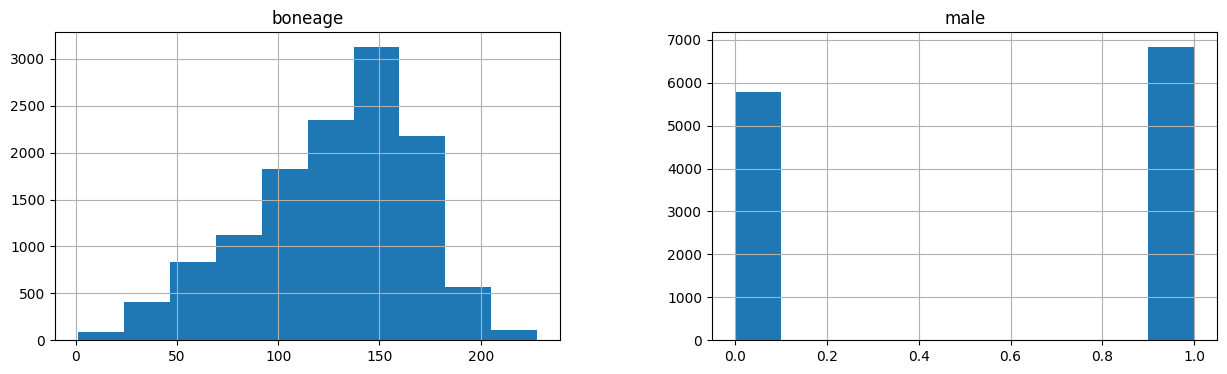

In [7]:
train_csv[['boneage', 'male']].hist(figsize=(15, 4))
plt.show()

## visualizing 4 samples whth according bonage value

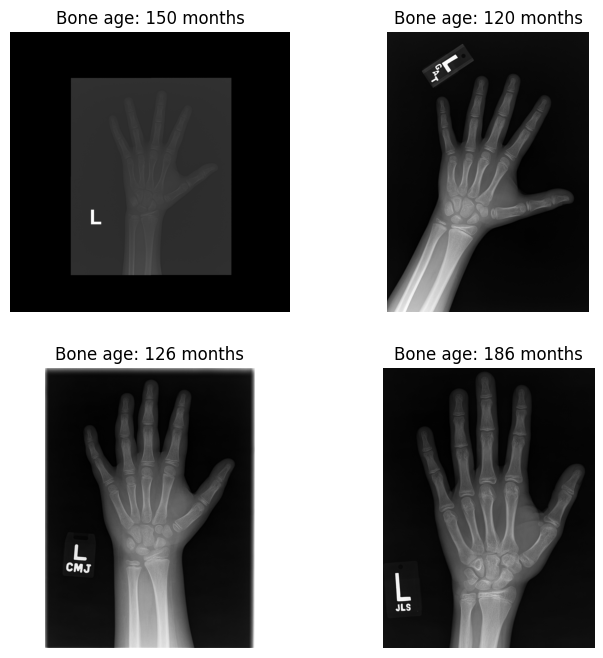

In [8]:
sample_data = train_csv[['boneage', 'imagePath']].sample(4).values

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(8,8))

for i, (bone_age, img_path) in enumerate(sample_data):
    img = cv2.imread(img_path)
    axs[i // 2, i % 2].imshow(img)
    axs[i // 2, i % 2].set_title(f'Bone age: {bone_age} months')
    axs[i // 2, i % 2].axis('off')

plt.show()

# **Data Preprocessing**

### Scaling using StandardScaler

In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_csv['scaled_boneage'] = scaler.fit_transform(train_csv[['boneage']])
train_csv.head()

,id,boneage,male,imagePath,scaled_boneage
0,1377,180,0,/kaggle/input/rsna-bone-age/boneage-training-d...,1.279231
1,1378,12,0,/kaggle/input/rsna-bone-age/boneage-training-d...,-2.800380
2,1379,94,0,/kaggle/input/rsna-bone-age/boneage-training-d...,-0.809141
3,1380,120,1,/kaggle/input/rsna-bone-age/boneage-training-d...,-0.177773
4,1381,82,0,/kaggle/input/rsna-bone-age/boneage-training-d...,-1.100542


### Splitting the dataset into validation and train

In [10]:
from sklearn.model_selection import train_test_split

# making subset to pass it to the train_test_split func as stratify:
# to ensure that the proportion of bone age values will remain consistent between validation and train dataset.
subsets = pd.cut(train_csv['boneage'], 19)

train_df, valid_df = train_test_split(train_csv,
                                      test_size=0.20,
                                      random_state=46,
                                      stratify=subsets)
print('train', train_df.shape, 'validation', valid_df.shape)

train (10088, 5) validation (2523, 5)


### Xception model input data generator

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.xception import preprocess_input

train_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
val_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

img_size = 256
batch_size = 32

# train data generator
train_generator = train_data_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='imagePath',
    y_col='scaled_boneage',
    batch_size=batch_size,
    seed=42,
    shuffle=True,
    class_mode='other',
    flip_vertical=True,
    color_mode='rgb',
    target_size=(img_size, img_size))

# validation data generator
val_generator = val_data_generator.flow_from_dataframe(
    dataframe=valid_df,
    x_col='imagePath',
    y_col='scaled_boneage',
    batch_size=batch_size,
    seed=42,
    shuffle=True,
    class_mode='other',
    flip_vertical=True,
    color_mode='rgb',
    target_size=(img_size, img_size))

Found 10088 validated image filenames.
Found 2523 validated image filenames.


### MAE to month convertor

In [12]:
from keras.metrics import mean_absolute_error

mean_boneage = train_csv['boneage'].mean()
std_boneage = train_csv['boneage'].std()

def mae_to_months(x_predicted, y_predicted):
    return mean_absolute_error((std_boneage * x_predicted + mean_boneage),
                               (std_boneage * y_predicted + mean_boneage))

print(std_boneage, mean_boneage)


41.182021399396326 127.3207517246848


# **Building model Architecture**

### Loading Xception architecture

In [13]:
from keras.applications.xception import Xception

Xception_model = Xception(input_shape=(img_size, img_size, 3),
                 include_top=False,
                 weights='imagenet')
Xception_model.save('xception_model.h5')

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


### Adding layers to Xception model 

In [14]:
from keras.models import load_model
from tensorflow.keras.layers import Input, GlobalMaxPooling2D, Dense, Flatten
from tensorflow.keras import Sequential


model0 = load_model('/kaggle/working/xception_model.h5')

model0.trainable = True
model = Sequential()
model.add(Input(shape=(img_size, img_size, 3))) 
model.add(model0)
model.add(GlobalMaxPooling2D())
model.add(Flatten())
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='linear'))

#compile model
model.compile(loss='mse', optimizer='adam', metrics=[mae_to_months])

#model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 8, 8, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ (None, 2048)           │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        20,490 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,881,981 (79.66 MB)

 Trainable params: 20,827,453 (79.45 MB)

 Non-trainable params: 54,528 (213.00 KB)

### Initializing required callbacks

In [15]:
from tensorflow.keras.callbacks import ModelCheckpoint

model_checkpoint = ModelCheckpoint('best_model_trained.keras', monitor='val_mae_to_months', mode='min', save_best_only=True)

callbacks = [model_checkpoint]

In [16]:
STEP_SIZE_TRAIN = int(np.ceil(train_generator.n//batch_size))
STEP_SIZE_VALID = int(np.ceil(val_generator.n//batch_size))

print(STEP_SIZE_TRAIN, STEP_SIZE_VALID)


315 78


### Training

In [17]:
history = model.fit(train_generator,
                    steps_per_epoch = STEP_SIZE_TRAIN,
                    validation_data = val_generator,
                    validation_steps = STEP_SIZE_VALID,
                    epochs = 10,
                    callbacks= callbacks)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1719159530.661640      89 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1719159530.727383      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 90/315 ━━━━━━━━━━━━━━━━━━━━ 6:16 2s/step - loss: 0.9905 - mae_to_months: 30.6775

W0000 00:00:1719159680.098600      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.5547 - mae_to_months: 22.2074

W0000 00:00:1719159986.340706      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


315/315 ━━━━━━━━━━━━━━━━━━━━ 654s 2s/step - loss: 0.5538 - mae_to_months: 22.1901 - val_loss: 0.3708 - val_mae_to_months: 20.7030
Epoch 2/10
  1/315 ━━━━━━━━━━━━━━━━━━━━ 2:46 532ms/step - loss: 0.1290 - mae_to_months: 11.6230

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


315/315 ━━━━━━━━━━━━━━━━━━━━ 17s 54ms/step - loss: 0.1290 - mae_to_months: 11.6230 - val_loss: 0.4983 - val_mae_to_months: 23.8168
Epoch 3/10


W0000 00:00:1719160102.138210      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


315/315 ━━━━━━━━━━━━━━━━━━━━ 387s 1s/step - loss: 0.1407 - mae_to_months: 12.1670 - val_loss: 0.1724 - val_mae_to_months: 13.7663
Epoch 4/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 1s 461us/step - loss: 0.1177 - mae_to_months: 11.1695 - val_loss: 0.1847 - val_mae_to_months: 14.5562
Epoch 5/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 386s 1s/step - loss: 0.1063 - mae_to_months: 10.5962 - val_loss: 0.1197 - val_mae_to_months: 10.9855
Epoch 6/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 1s 463us/step - loss: 0.1146 - mae_to_months: 11.2817 - val_loss: 0.1312 - val_mae_to_months: 11.5531
Epoch 7/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 383s 1s/step - loss: 0.0759 - mae_to_months: 8.9122 - val_loss: 0.1622 - val_mae_to_months: 12.6389
Epoch 8/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 1s 981us/step - loss: 0.0875 - mae_to_months: 9.9373 - val_loss: 0.1460 - val_mae_to_months: 11.2052
Epoch 9/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 382s 1s/step - loss: 0.0608 - mae_to_months: 7.9968 - val_loss: 0.1744 - val_mae_to_months: 13.9164
Epoch 10/10
315/315 ━━━━

### Plotting MAE and loss vs number of epochs

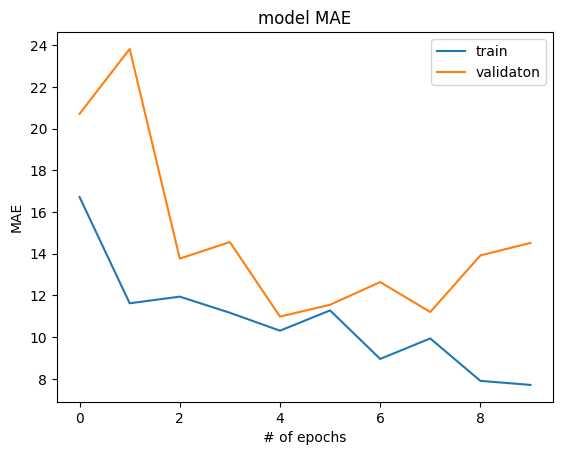

In [24]:
plt.plot(history.history['mae_to_months'])
plt.plot(history.history['val_mae_to_months'])
plt.legend(['train','validaton'])
plt.title('model MAE')
plt.ylabel('MAE')
plt.xlabel('# of epochs')
plt.show()

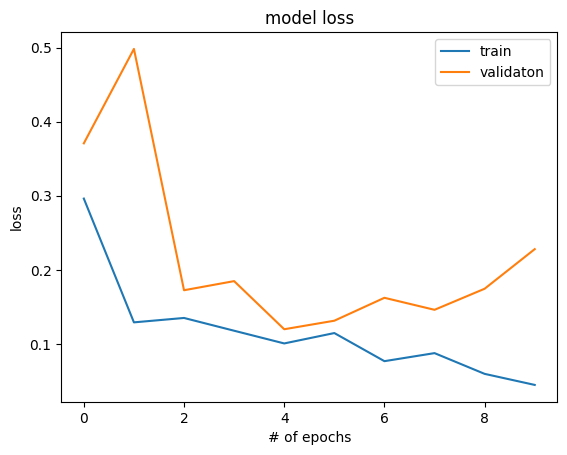

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validaton'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('# of epochs')
plt.show()

# Final results

In [26]:
model.load_weights('/kaggle/working/best_model_trained.keras')

In [45]:
evaluation = model.evaluate(val_generator)

79/79 ━━━━━━━━━━━━━━━━━━━━ 75s 944ms/step - loss: 0.1202 - mae_to_months: 10.8837


### Plotting some samples from validation set with predicted and actual values

In [41]:
valid_X, valid_Y = next( val_data_generator.flow_from_dataframe(
                            dataframe=valid_df,
                            x_col='imagePath',
                            y_col='scaled_boneage',
                            batch_size=2523,
                            class_mode='other',)) 


Found 2523 validated image filenames.


In [48]:
pred = mean_boneage + std_boneage*(model.predict(valid_X, batch_size = 32, verbose = True))
test_months = mean_boneage + std_boneage*(valid_Y)

79/79 ━━━━━━━━━━━━━━━━━━━━ 12s 152ms/step


/tmp/ipykernel_34/1197978085.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_age = float(pred[idx] / 12.0)


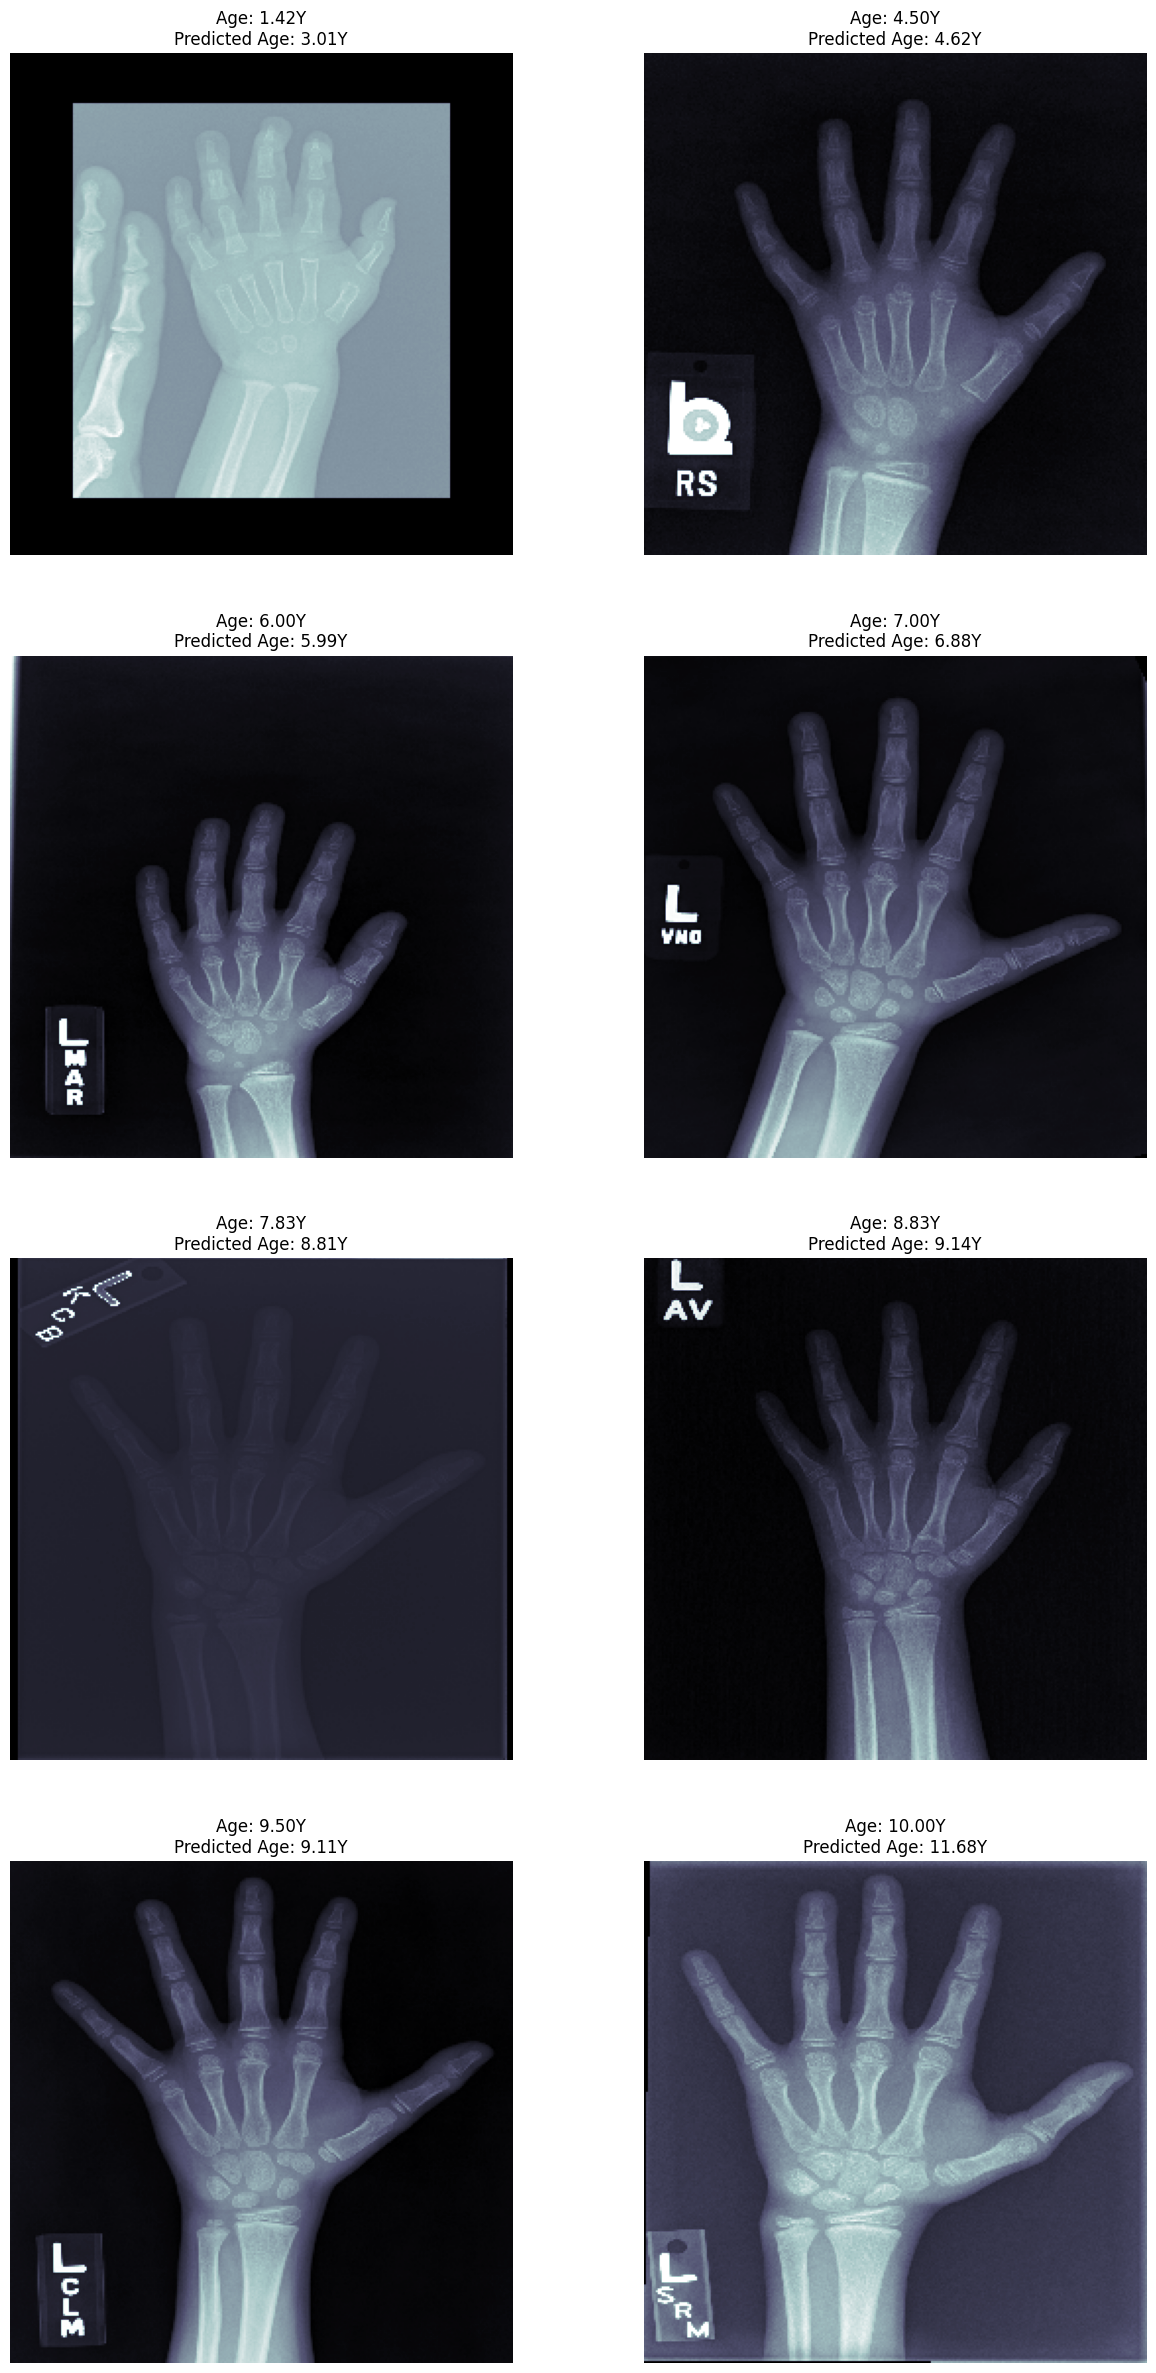

In [58]:
sorted_indices = np.argsort(valid_Y)
evenly_spaced_indices = sorted_indices[np.linspace(10, len(sorted_indices) - 1, 19).astype(int)]

fig, axs = plt.subplots(4, 2, figsize = (15, 30))

for idx, ax in zip(evenly_spaced_indices, axs.flatten()):
    
    ax.imshow(valid_X[idx, :, :, 0], cmap='bone')
    
    actual_age = float(test_months[idx] / 12.0)
    predicted_age = float(pred[idx] / 12.0)
    
    ax.set_title(f'Age: {actual_age:.2f}Y\nPredicted Age: {predicted_age:.2f}Y')
    
    ax.axis('off')
    
plt.show()